Se ha creado un final muerto en el nodo 1: K
Se ha creado un final muerto en el nodo 2: N
Matriz de Transición
      A     B     C     D     E     F     G     H     I     J     K     L  \
A  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.44  0.01  0.01   
B  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01   
C  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01   
D  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.44  0.01  0.01  0.01   
E  0.44  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01   
F  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.44   
G  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
H  0.01  0.01  0.01  0.01  0.01  0.01  0.29  0.01  0.01  0.01  0.29  0.29   
I  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01   
J  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.44   
K  0.01  0.01  0.01  0.01  0.01  0.01  0.0

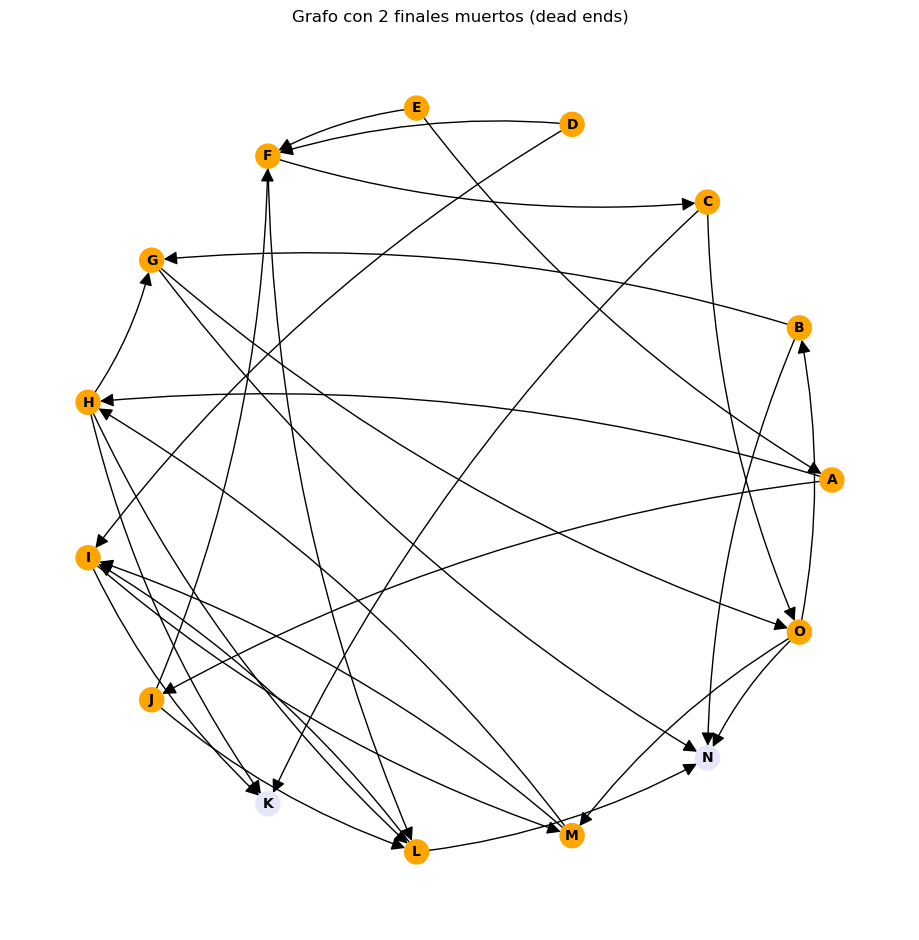

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

# Variables refactorizadas
dead_end_nodes = []  # Dead end nodes
graph_matrix = []
total_nodes = 15  # Total number of nodes

# Mapeo de números a letras
letter_map = {i+1: chr(65+i) for i in range(total_nodes)}  # {1: 'A', 2: 'B', ..., 15: 'O'}

# Reorganización de las funciones

def adjacency_matrix(G):
    # Convertir a una matriz estocástica
    adjacency_matrix = nx.to_numpy_array(G, nodelist=list(G.nodes))  # Usamos las letras como nodos

    # Normalizar filas para que sumen 1
    normalized_matrix = np.array(adjacency_matrix, dtype=float)
    row_sums = normalized_matrix.sum(axis=1, keepdims=True)
    
    # Si la fila es cero (final muerto), permitir teletransportación uniforme
    row_sums[row_sums == 0] = 1.0  # Evitar divisiones por cero
    transition_matrix = normalized_matrix / row_sums
    
    # Agregar probabilidad de teletransportación
    teleport_prob = 0.15
    final_matrix = teleport_prob / total_nodes + (1 - teleport_prob) * transition_matrix
    return np.round(final_matrix, 2)

def power_iteration_trace(transition_matrix, d=0.85, teleport_steps=None, verbose=False, max_iterations=100):
    N = transition_matrix.shape[0]
    rank_vector = np.ones(N) / N  # Vector inicial de distribución uniforme
    trace = [rank_vector.copy()]  # Guardar estado inicial

    tolerance = 1e-4  # Tolerancia de cambio
    delta = tolerance + 1
    iteration = 0

    while delta > tolerance and iteration < max_iterations:
        iteration += 1

        # Aplicar fórmula PageRank con teletransportación
        new_rank_vector = d * np.dot(transition_matrix.T, rank_vector) + (1 - d) / N

        # Normalizar para que la suma sea 1
        new_rank_vector /= np.sum(new_rank_vector)

        # Comparar la diferencia entre el vector anterior y el nuevo
        delta = np.linalg.norm(new_rank_vector - rank_vector, 1)  # Norma L1

        if verbose:
            rank_str = np.array2string(new_rank_vector, precision=4, separator=', ', suppress_small=True)
            print(f"Iteración {iteration}:\n {rank_str}\nCambio: {delta}")

        rank_vector = new_rank_vector.copy()
        trace.append(rank_vector.copy())

    return trace  # Lista de vectores para cada iteración

def walker_simulation(matrix):
    unvisited_nodes = set(nodes)
    current_position = random.choice(nodes)
    path_traveled = [current_position]
    print("El camino aleatorio empieza en:", current_position)
    counter = 0
    teleports = []
    iterations = 1  # Contador de iteraciones

    while unvisited_nodes:
        counter += 1

        if current_position in dead_end_nodes:
            print(f"Has llegado a un final muerto en el nodo: {current_position}")
            user_input = input("¿Quieres teletransportarte? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                print("¡Te quedas en el final muerto!")
        else:
            # Obtener probabilidades de transición para el nodo actual
            transition_probs = matrix.loc[current_position].values
            transition_probs /= transition_probs.sum()

            user_input = input("¿Teletransportación? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                current_position = np.random.choice(nodes, p=transition_probs)

        # Iteraciones con Power Iteration
        power_iteration_trace(matrix, 0.85, teleports, True, iterations)

        # Incrementar el contador global
        iterations += 1

        # Añadir el nodo al camino recorrido
        path_traveled.append(current_position)
        print("Ruta del caminante aleatorio:", path_traveled)

        # Marcar el nodo como visitado
        if current_position in unvisited_nodes:
            unvisited_nodes.remove(current_position)

        # Verificar si todos los nodos han sido visitados
        if not unvisited_nodes:
            print("¡Todos los nodos han sido visitados!")
            break

        # Preguntar si continuar
        user_input = input("¿Deseas continuar con el recorrido? (s/n): ").lower()
        if user_input != 's':
            break

    return path_traveled

def add_random_connections(G, nodes):
    max_edges = 2  # Limitar a 2 conexiones por nodo para mantener simplicidad
    for node in nodes:
        if node not in dead_end_nodes:
            available_targets = [target for target in nodes if target != node]
            number_of_edges = min(max_edges, len(available_targets))  # Elegir un número limitado de conexiones
            if number_of_edges > 0:
                selected_targets = random.sample(available_targets, number_of_edges)
                for target in selected_targets:
                    G.add_edge(node, target)
    return G

def display_graph(G):
    # Crear un diccionario de colores para los nodos
    colors = ['lavender' if node in dead_end_nodes else 'orange' for node in G.nodes]
    
    plt.figure(figsize=(9, 9))
    positions = nx.circular_layout(G)
    
    # Las letras ya están etiquetadas como nodos
    labels = {node: node for node in G.nodes}
    
    nx.draw(G, positions, labels=labels, node_color=colors, font_size=10, font_color="black", font_weight="bold", arrowsize=20, connectionstyle="arc3,rad=0.1")
    plt.title("Grafo con 2 finales muertos (dead ends)")

def generate_graph_with_nodes(node_count):
    G = nx.DiGraph()
    # Crear nodos con etiquetas de letras
    nodes = list(letter_map.values())  # Utilizamos las letras directamente como nodos
    for node in nodes:
        weight = random.uniform(0.1, 1.0)
        G.add_node(node, weight=weight)
    return G, nodes

def introduce_dead_ends(G, nodes):
    previous_node = None
    for i in range(2):  # Agregar 2 dead ends
        dead_end = random.choice([n for n in nodes if n not in dead_end_nodes and n != previous_node])
        dead_end_nodes.append(dead_end)
        connecting_node = random.choice([n for n in nodes if n not in dead_end_nodes and n != previous_node])

        G.add_edge(connecting_node, dead_end)  # Agregar arista hacia el dead end
        previous_node = connecting_node
        print(f"Se ha creado un final muerto en el nodo {i+1}: {dead_end}")

    return G

if __name__ == "__main__":
    # Inicializar el grafo
    G, nodes = generate_graph_with_nodes(total_nodes)
    G = introduce_dead_ends(G, nodes)
    G = add_random_connections(G, nodes)

    # Convertir la matriz de adyacencia en un DataFrame
    adj_matrix_df = pd.DataFrame(adjacency_matrix(G), index=nodes, columns=nodes)
    print("Matriz de Transición")
    print(adj_matrix_df)

    # Dibujar el grafo
    display_graph(G)

In [ ]:
recorrido = walker_simulation(adj_matrix_df)
print("Recorrido del Random Walker: ", recorrido)

Spider Trap 1: D -> O -> C
Spider Trap 2: E -> I -> G
Matriz de Transición
      A     B     C     D     E     F     G     H     I     J     K     L  \
A  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01   
B  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
C  0.01  0.01  0.01  0.86  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
D  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
E  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.44  0.01  0.01  0.01   
F  0.01  0.01  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.01  0.01  0.44   
G  0.01  0.01  0.01  0.01  0.86  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
H  0.44  0.01  0.44  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
I  0.01  0.01  0.01  0.01  0.01  0.01  0.86  0.01  0.01  0.01  0.01  0.01   
J  0.01  0.01  0.01  0.01  0.44  0.01  0.01  0.44  0.01  0.01  0.01  0.01   
K  0.01  0.01  0.01  0.01  0.44  0.44  0.01  0.01  0.01  0.01  0.01  0.01   
L

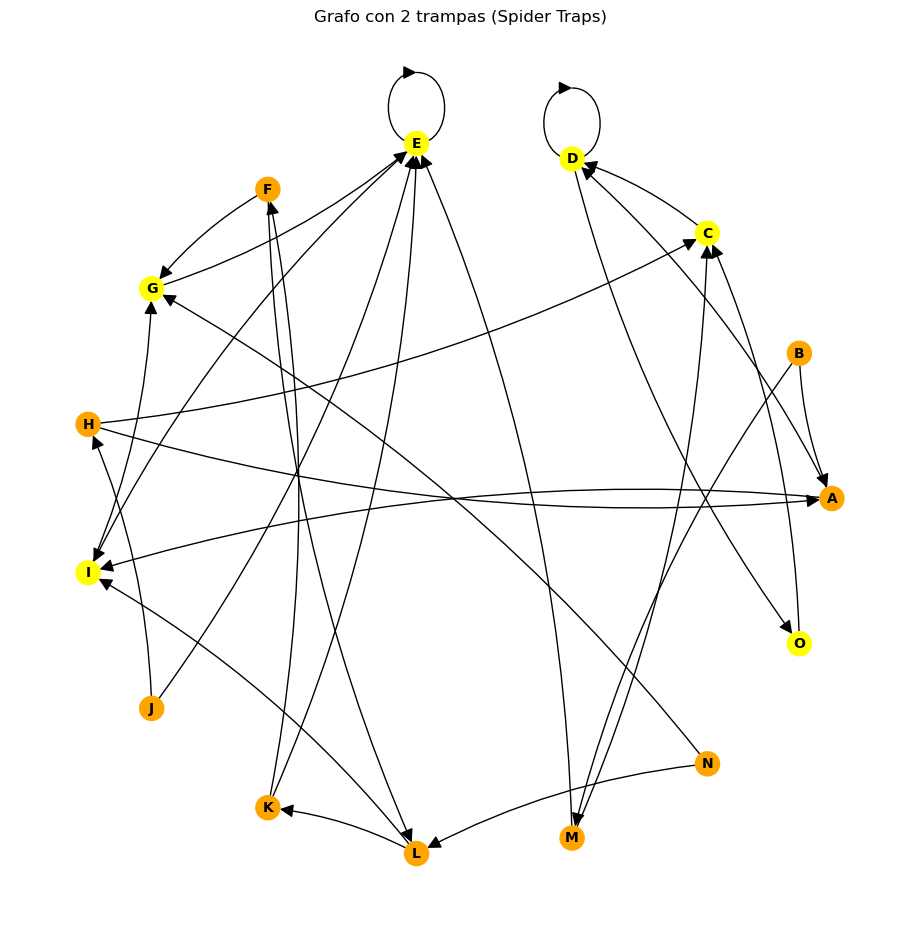

In [10]:
# Variables refactorizadas
spider_trap_nodes = []  # Spider Trap nodes

def walker_simulation_for_spiders(matrix):
    unvisited_nodes = set(nodes)
    current_position = random.choice(nodes)
    path_traveled = [current_position]
    print("El camino aleatorio empieza en:", current_position)
    counter = 0
    teleports = []
    iterations = 1  # Contador de iteraciones

    while unvisited_nodes:
        counter += 1

        if current_position in spider_trap_nodes:
            print(f"Has llegado a un spider trap en el nodo: {current_position}")
            user_input = input("¿Quieres teletransportarte? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                print("¡Te quedas en el spider trap!")
        else:
            # Obtener probabilidades de transición para el nodo actual
            transition_probs = matrix.loc[current_position].values
            transition_probs /= transition_probs.sum()

            user_input = input("¿Teletransportación? (s/n): ").lower()
            if user_input == "s":
                current_position = random.choice([n for n in nodes if n in unvisited_nodes])
                print("Teletransportado a:", current_position)
                teleports.append(iterations)
            else:
                current_position = np.random.choice(nodes, p=transition_probs)

        # Iteraciones con Power Iteration
        power_iteration_trace(matrix, 0.85, teleports, True, iterations)

        # Incrementar el contador global
        iterations += 1

        # Añadir el nodo al camino recorrido
        path_traveled.append(current_position)
        print("Ruta del caminante aleatorio:", path_traveled)

        # Marcar el nodo como visitado
        if current_position in unvisited_nodes:
            unvisited_nodes.remove(current_position)

        # Verificar si todos los nodos han sido visitados
        if not unvisited_nodes:
            print("¡Todos los nodos han sido visitados!")
            break

        # Preguntar si continuar
        user_input = input("¿Deseas continuar con el recorrido? (s/n): ").lower()
        if user_input != 's':
            break

    return path_traveled

def introduce_spider_traps(G, nodes):
    for i in range(2):  # Crear 3 Spider Traps
        spider_trap = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(spider_trap)
        next_node = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(next_node)
        next_node2 = random.choice([n for n in nodes if n not in spider_trap_nodes])
        spider_trap_nodes.append(next_node2)

        G.add_edge(spider_trap, spider_trap)  # Conexión consigo mismo
        G.add_edge(spider_trap, next_node)
        G.add_edge(next_node, next_node2)
        G.add_edge(next_node2, spider_trap)

        print(f"Spider Trap {i + 1}: {spider_trap} -> {next_node} -> {next_node2}")

    return G

def add_random_connections_for_spiders(G, nodes):
    max_edges = 2  # Limitar a 2 conexiones por nodo para mantener simplicidad
    for node in nodes:
        if node not in spider_trap_nodes:
            available_targets = [target for target in nodes if target != node]
            number_of_edges = min(max_edges, len(available_targets))  # Elegir un número limitado de conexiones
            if number_of_edges > 0:
                selected_targets = random.sample(available_targets, number_of_edges)
                for target in selected_targets:
                    G.add_edge(node, target)
    return G

def display_graph_for_spiders(G):
    # Crear un diccionario de colores para los nodos
    colors = ['yellow' if node in spider_trap_nodes else 'orange' for node in G.nodes]
    
    plt.figure(figsize=(9, 9))
    positions = nx.circular_layout(G)
    
    # Las letras ya están etiquetadas como nodos
    labels = {node: node for node in G.nodes}
    
    nx.draw(G, positions, labels=labels, node_color=colors, font_size=10, font_color="black", font_weight="bold", arrowsize=20, connectionstyle="arc3,rad=0.1")
    plt.title("Grafo con 2 trampas (Spider Traps)")

if __name__ == "__main__":
    # Inicializar el grafo
    G, nodes = generate_graph_with_nodes(total_nodes)
    G = introduce_spider_traps(G, nodes)
    G = add_random_connections_for_spiders(G, nodes)

    # Convertir la matriz de adyacencia en un DataFrame
    adj_matrix_df = pd.DataFrame(adjacency_matrix(G), index=nodes, columns=nodes)
    print("Matriz de Transición")
    print(adj_matrix_df)

    # Dibujar el grafo
    display_graph_for_spiders(G)

In [11]:
recorrido_2 = walker_simulation_for_spiders(adj_matrix_df)
print("Recorrido del Random Walker: ", recorrido_2)

El camino aleatorio empieza en: K
Teletransportado a: F
Iteración 1:
 [0.0668, 0.0184, 0.1147, 0.1147, 0.163 , 0.0424, 0.1147, 0.0426, 0.0911,
 0.0184, 0.0426, 0.0668, 0.0426, 0.0184, 0.0426]
Cambio: 0.5306099320571763
Ruta del caminante aleatorio: ['K', 'F']
Teletransportado a: O
Iteración 1:
 [0.0669, 0.0184, 0.1148, 0.1148, 0.163 , 0.0424, 0.1146, 0.0426, 0.0911,
 0.0184, 0.0426, 0.0666, 0.0426, 0.0184, 0.0426]
Cambio: 0.5304483766454448
Iteración 2:
 [0.0406, 0.0184, 0.0801, 0.1671, 0.1977, 0.0338, 0.1059, 0.0251, 0.1263,
 0.0184, 0.0427, 0.0404, 0.0251, 0.0184, 0.0602]
Cambio: 0.27926060263900976
Ruta del caminante aleatorio: ['K', 'F', 'O']
Has llegado a un spider trap en el nodo: O
Teletransportado a: H
Iteración 1:
 [0.0669, 0.0184, 0.1148, 0.1148, 0.163 , 0.0424, 0.1146, 0.0426, 0.0911,
 0.0184, 0.0426, 0.0666, 0.0426, 0.0184, 0.0426]
Cambio: 0.5304483766454448
Iteración 2:
 [0.0406, 0.0184, 0.0801, 0.1671, 0.1977, 0.0338, 0.1059, 0.0251, 0.1263,
 0.0184, 0.0427, 0.0404, 0.025